[View in Colaboratory](https://colab.research.google.com/github/roman807/TGS_Salt/blob/master/unet_10_23.ipynb)

U-Net: train model and evaluate results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras import optimizers, initializers
from keras import backend as K
from sklearn.metrics import confusion_matrix, log_loss
from google.colab import files
import tensorflow as tf
import cv2
import os
import json
import zipfile
import skimage.io as io
import skimage.transform as trans
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

Using TensorFlow backend.


In [0]:
# ------------------- Load data (use kaggle API) ------------------- #
!pip install kaggle
api_token = {"username":"#############","key":"###############################"}
os.chdir('/')
!mkdir ~/.kaggle #kaggle API searches in root directory for .kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# API link from Kaggle:
!kaggle competitions download -c tgs-salt-identification-challenge
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
# ------------------- Prepare data ------------------- #
tr_image_dir = os.chdir('/images')
train_im = os.listdir(tr_image_dir)
x1 = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_im]) / 255
x2 = np.flip(x1, 2)
tr_masks_dir = os.chdir('/masks')
train_ma = os.listdir(tr_masks_dir)
y1 = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_ma]) / 255
y2 = np.flip(y1, 2)
x = np.append(x1, x2, axis=0)
y = np.append(y1, y2, axis=0)

# expand dimensions for CNN
x = np.expand_dims(x, axis=3)
y = np.expand_dims(y, axis=3)

# split training vs validation set
train_val_split = 0.05
x_train = np.concatenate([ x[0:int(x1.shape[0]*(1-train_val_split)),:,:,:], 
    x[x1.shape[0]:int(x1.shape[0] + x1.shape[0]*(1-train_val_split)),:,:,:] ])
y_train = np.concatenate([ y[0:int(y1.shape[0]*(1-train_val_split)),:,:,:], 
    y[y1.shape[0]:int(y1.shape[0] + y1.shape[0]*(1-train_val_split)),:,:,:] ])
x_val = np.concatenate([ x[int(x1.shape[0]*(1-train_val_split)):int(x1.shape[0]),:,:,:], 
    x[int(x1.shape[0]+x1.shape[0]*(1-train_val_split)):,:,:,:] ])
y_val = np.concatenate([ y[int(y1.shape[0]*(1-train_val_split)):int(y1.shape[0]),:,:,:], 
    y[int(y1.shape[0]+y1.shape[0]*(1-train_val_split)):,:,:,:] ])

In [0]:
# ------------------- Define model ------------------- #
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

def unet(pretrained_weights = None, input_size=(101,101,1)):
    inputs = Input(input_size)
    input_padded = ZeroPadding2D(padding=((14, 13), (14, 13)))(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializer)(input_padded)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv1)
    conv1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv1)
    conv1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv2)
    conv2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv2)
    conv2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv3)
    conv3 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv3)
    conv3 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv4)
    conv4 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv4)
    conv4 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv4)#(drop4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializer)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv5)
    conv5 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv5)
    conv5 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=initializer)(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv6)
    conv6 = Conv2D(1024, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv6)
    conv6 = Conv2D(1024, 2, activation='relu', padding='same', kernel_initializer=initializer)(conv6)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer=initializer)\
        (UpSampling2D(size = (2,2))(conv6))
    merge6 = merge([conv5, up6], mode='concat', concat_axis = 3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializer)(merge6)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv7)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=initializer)\
        (UpSampling2D(size = (2,2))(conv7))
    merge7 = merge([conv4, up7], mode='concat', concat_axis = 3)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(merge7)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv8)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=initializer)\
        (UpSampling2D(size=(2,2))(conv8))
    merge8 = merge([conv3, up8], mode='concat', concat_axis = 3)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(merge8)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv9)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initializer)\
        (UpSampling2D(size = (2,2))(conv9))
    merge9 = merge([conv2, up9], mode='concat', concat_axis=3)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(merge9)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv10)
    up10 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initializer)\
        (UpSampling2D(size = (2,2))(conv10))
    merge10 = merge([conv1, up10], mode='concat', concat_axis=3)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(merge10)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv11)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv11)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(conv11)
    conv11 = Conv2D(1, 1, activation='sigmoid')(conv11)
    crop = Cropping2D(cropping=((14, 13), (14, 13)))(conv11)
    model = Model(inputs=inputs, output=crop)
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model

In [0]:
# ------------------- Define evaluation metrics [NOT IN USE] ------------------- #
# class MeanIoU(object):
#     def __init__(self):
#         super().__init__()
#     def mean_iou(self, y_true, y_pred):
#         # Wraps np_mean_iou method and uses it as a TensorFlow op.
#         # Takes numpy arrays as its arguments and returns numpy arrays as outputs
#         return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float64)
#     def np_mean_iou(self, y_true, y_pred):
#         y_pred = np.round(y_pred + 0.05, 0).reshape(-1)
#         y_true = y_true.reshape(-1)        
#         conf = confusion_matrix(y_pred, y_true)        
#         # Compute the IoU and mean IoU from the confusion matrix:
#         true_positive = conf[1,1]
#         false_positive = conf[1,0]
#         false_negative = conf[0,1]
#         # Just in case we get a division by 0, ignore/hide the error and set the value to 0
#         with np.errstate(divide='ignore', invalid='ignore'):
#             iou = true_positive / (true_positive + false_positive + false_negative)
#         #iou[np.isnan(iou)] = 0
#         return np.mean(iou).astype(np.float64)
# miou = MeanIoU()
# def bin_acc05(y_true, y_pred):
#     return K.mean(K.equal(y_true, K.round(y_pred + 0.05)), axis=-1)

In [13]:
# ------------------- Compile model ------------------- #
model = unet()
adam = optimizers.Adam(lr = 1e-4)   # <-- changed to 1e-4 from default: 1e-3
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 128, 128, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 128, 128, 32) 320         zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_191[0][0]                 
__________________________________________________________________________________________________
conv2d_193

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("cr...)`


In [0]:
# ------------------- Run model ------------------- #
filepath = 'weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(x_train, y_train, epochs=25, batch_size=8, validation_data=(x_val,y_val), callbacks=callbacks_list, verbose=1)

In [15]:
# ------------------- Make predictions ------------------- #
model.load_weights('weights.best.hdf5')
y_train_pred = model.predict(x_train, verbose=1)
y_val_pred = model.predict(x_val, verbose=1)

400/400 [==============================] - 4s 10ms/step


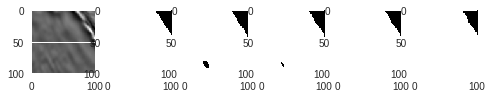

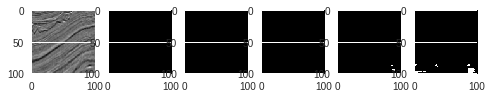

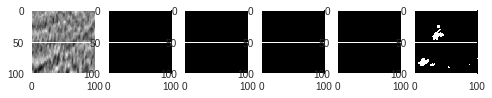

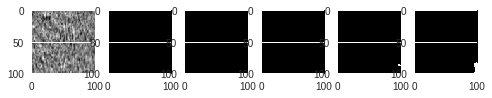

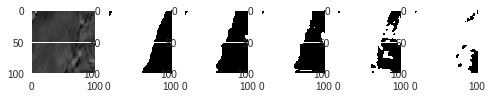

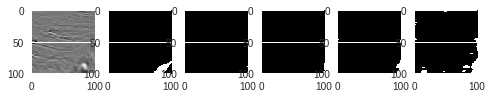

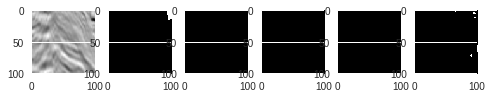

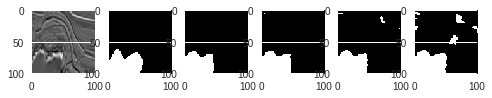

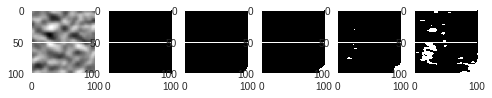

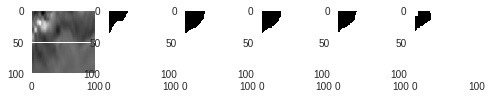

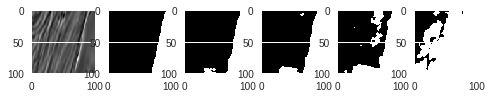

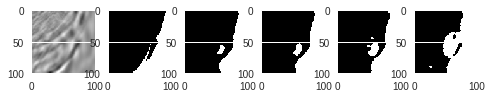

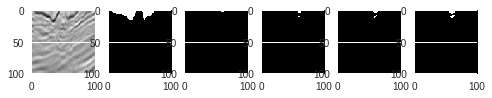

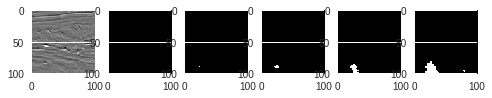

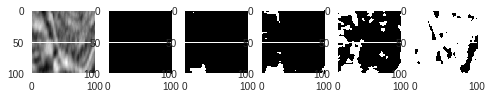

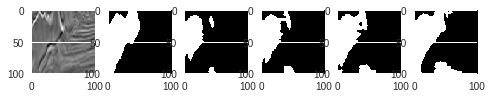

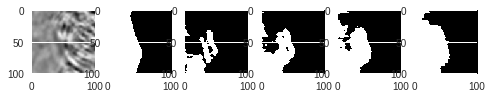

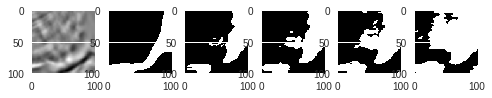

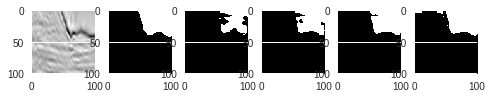

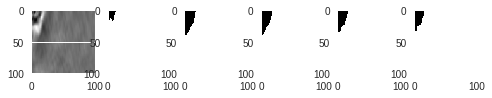

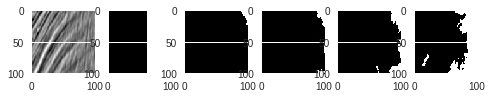

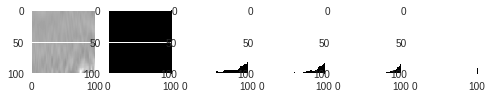

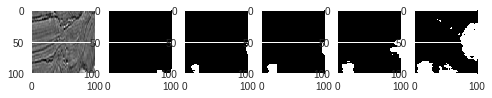

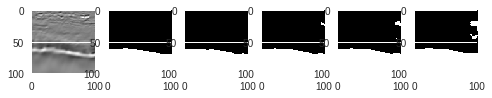

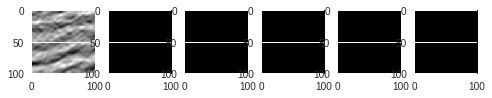

In [18]:
# ------------------- Check validation pictures ------------------- #
for i in range(len(y_val_pred[:25])):
  fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
  ax1.imshow(x_val[i,:,:,0], cmap='binary_r', vmin=0, vmax=1)
  ax2.imshow(y_val[i,:,:,0], cmap='binary_r', vmin=0, vmax=1)
  ax3.imshow(np.round(y_val_pred[i,:,:,0]), cmap='binary_r', vmin=0, vmax=1)
  ax4.imshow(np.round(y_val_pred[i,:,:,0]+.1), cmap='binary_r', vmin=0, vmax=1)
  ax5.imshow(np.round(y_val_pred[i,:,:,0]+.2), cmap='binary_r', vmin=0, vmax=1)
  ax6.imshow(np.round(y_val_pred[i,:,:,0]+.3), cmap='binary_r', vmin=0, vmax=1)
  plt.show()

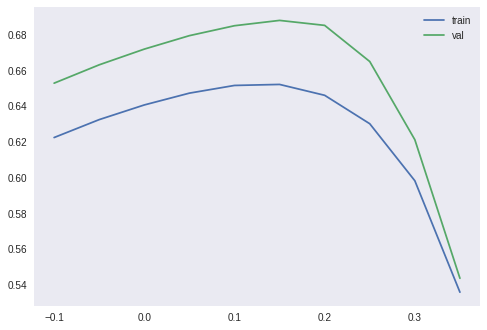

mean IOU training: 0.6472250319682964
mean IOU validation: 0.6793871515761656
loss training: 0.27674353146874275
loss validation: 0.2444340144965253


In [19]:
# ------------------- Evaluate results ------------------- #
y_train = y_train.reshape(-1)[:(400*101*101)]
y_train_pred = y_train_pred.reshape(-1)[:(400*101*101)]
y_val = y_val.reshape(-1)
y_val_pred = y_val_pred.reshape(-1)

true_positive_train = []
false_positive_train = []
false_negative_train = []
iou_train = []
true_positive_val = []
false_positive_val = []
false_negative_val = []
iou_val = []
thresh = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
for i in thresh:
    y_train_pred_bin = np.round(y_train_pred + i, 0)
    y_val_pred_bin = np.round(y_val_pred + i, 0)
    conf_train = confusion_matrix(y_train_pred_bin, y_train)
    true_positive_train.append(conf_train[1,1])
    false_positive_train.append(conf_train[1,0])
    false_negative_train.append(conf_train[0,1])
    iou_train.append(conf_train[1,1]/(conf_train[1,1]+conf_train[1,0]+conf_train[0,1]))
    conf_val = confusion_matrix(y_val_pred_bin, y_val)
    true_positive_val.append(conf_val[1,1])
    false_positive_val.append(conf_val[1,0])
    false_negative_val.append(conf_val[0,1])
    iou_val.append(conf_val[1,1]/(conf_val[1,1]+conf_val[1,0]+conf_val[0,1]))
d = {'true_positive_train': true_positive_train, 'false_positive_train':  \
     false_positive_train, 'false_negative_train': false_negative_train, \
     'iou_train': iou_train, 'true_positive_val': true_positive_val, 'false_positive_val':  \
     false_positive_val, 'false_negative_val': false_negative_val, 'iou_val': iou_val, }
df = pd.DataFrame.from_dict(d, orient='index')
df.columns = ['-0.1', '-0.05', '0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35']
plt.plot(thresh, iou_train) 
plt.plot(thresh, iou_val)
plt.legend(['train', 'val'])
plt.grid()
plt.show()

i = 0.05 # <- lower threshold for positive predictions (i.e: i=0.01 --> threshold=0.45)
y_train_pred_bin = np.round(y_train_pred + i, 0)
y_val_pred_bin = np.round(y_val_pred + i, 0)
loss_train = log_loss(y_train, y_train_pred)
loss_val = log_loss(y_val, y_val_pred)               
print('mean IOU training: ' + str(iou_train[3]))
print('mean IOU validation: ' + str(iou_val[3]))
print('loss training: ' + str(loss_train))
print('loss validation: ' + str(loss_val))

In [0]:
# ------------------- Save model and weights ------------------- #
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# 2. Save Keras Model or weights on google drive
# create on Colab directory
model.save('model_3322rn8.h5')    
model_file = drive.CreateFile({'title' : 'model_3322rn8.h5'})
model_file.SetContentFile('model_3322rn8.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})
model.save_weights('model_weights_3322rn8.h5')
weights_file = drive.CreateFile({'title' : 'model_weights_3322rn8.h5'})
weights_file.SetContentFile('model_weights_3322rn8.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})